In [1]:
# https://www.yutaka-note.com/entry/matplotlib_inline
%matplotlib inline

In [2]:
import collections
from collections import Counter
import pycircos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
from Bio import SeqIO 
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

In [3]:
# define the UP or DOWN regulated genes
direction = "UP"

# define the input file
HUMAN_CHROMOSOME = "../data/chromosome/chromosome_human.tsv"
RICE_CHROMOSOME  = "../data/chromosome/chromosome_rice.tsv"
#HN-score
HUMAN_SCORE = "../data/human/human_position_up.tsv"
RICE_SCORE  = "../data/rice_position_up.tsv"
# GOslim
HUMAN_GOSLIM = "../data/human/biomart_human_goslim_R110.tsv" # release 110
RICE_GOSLIM = "../data/biomart_rice_goslim_R56.tsv" # release 56


# define the output file
COMBINED_CHROMOSOME = "../data/chromosome/HR_combined.tsv"
COMBINED_SCORE = f"../data/HR_combined_score_{direction}.tsv"
HUMAN_NO_ANNOTATION = f"../data/human/left_only_rows_{direction}.tsv"
HUMAN_EXTRACT_GOSLIM_GENE = f"../data/human/human_df_h_goslim_{direction}.tsv"
RICE_NO_ANNOTATION = f"../data/rice_left_only_rows_{direction}.tsv"
RICE_EXTRACT_GOSLIM_GENE = f"../data/rice_df_r_goslim_{direction}.tsv"

COMBINED_GOSLIM = f"../data/merged_df_goslim_{direction}.tsv"
COMBINED_GOSLIM_SORTED = f"../data/merged_df_goslim_sorted_{direction}.tsv"

In [4]:
#organism = "human"
df = pd.read_csv(HUMAN_CHROMOSOME, sep='\t')
df_subset = df[['chr', 'start', 'end']].copy()
df_subset['chr'] = 'H_' + df_subset['chr'].astype(str)
df_subset['organism'] = 'human'# タグをつける


# organism = "rice"
df1 = pd.read_csv(RICE_CHROMOSOME, sep='\t')
df1_subset = df1[['chr', 'start', 'end']].copy()
df1_subset['chr'] = 'R_' + df1_subset['chr'].astype(str)    
df1_subset['organism'] = 'rice'# タグをつける

combined_df = pd.concat([df_subset, df1_subset])
combined_df.reset_index(drop=True, inplace=True)
combined_df.to_csv(COMBINED_CHROMOSOME, sep='\t', index=False)
combined_df

chr  start        end organism
0    H_1      1  248956422    human
1    H_2      1  242193529    human
2    H_3      1  198295559    human
3    H_4      1  190214555    human
4    H_5      1  181538259    human
5    H_6      1  170805979    human
6    H_7      1  159345973    human
7    H_8      1  145138636    human
8    H_9      1  138394717    human
9   H_10      1  133797422    human
10  H_11      1  135086622    human
11  H_12      1  133275309    human
12  H_13      1  114364328    human
13  H_14      1  107043718    human
14  H_15      1  101991189    human
15  H_16      1   90338345    human
16  H_17      1   83257441    human
17  H_18      1   80373285    human
18  H_19      1   58617616    human
19  H_20      1   64444167    human
20  H_21      1   46709983    human
21  H_22      1   50818468    human
22   H_X      1  156040895    human
23   H_Y      1   57227415    human
24   R_1      1   43270923     rice
25   R_2      1   35937250     rice
26   R_3      1   36413819     rice
27   R_4      1   35502694     rice
28   R_5      1   29958434     rice
29   R_6      1   31248787     rice
30   R_7      1   29697621     rice
31   R_8      1   28443022     rice
32   R_9      1   23012720     rice
33  R_10      1   23207287     rice
34  R_11      1   29021106     rice
35  R_12      1   27531856     rice
36  R_Mt      1     490520     rice
37  R_Pt      1     134525     rice
38  R_B1      1       2135     rice

In [5]:
# Initialize
circle = Gcircle(figsize=(12,12))

# Set Chromosome Data
n = 935
m = 985

# Read the combined DataFrame
for index, row in combined_df.iterrows():
    name = row['chr']
    length = row['end']
    organism = row['organism']
    
    # 染色体番号だけを取得
    chrom_number_str = name.split('_')[1] # "H_1" -> "1"
    
    try:
        chrom_number = int(chrom_number_str)
        if organism == 'human':
            color = plt.cm.Blues(chrom_number / 24)  # 22+X+Yで動的に色を変える
        else:
            color = plt.cm.Greens(chrom_number / 14)  # 12+X+Yで動的に色を変える
    except ValueError:  # "X", "Y", "Mt", "Pt"など、数値に変換できない場合
        if chrom_number_str == "X":
            color = plt.cm.Blues(23 / 24)
        elif chrom_number_str == "Y":
            color = plt.cm.Blues(24 / 24)
        elif chrom_number_str == "Mt":
            color = plt.cm.Greens(13 / 14)
        elif chrom_number_str == "Pt":
            color = plt.cm.Greens(14 / 14)
        else:
            color = 'grey'
    
    arc = Garc(arc_id=name, 
               size=length, 
               interspace=0.5, 
               raxis_range=(n, m), 
               labelposition=int(30 + (m-n)/2),
               labelsize=7,
               label_visible=True,
               facecolor=color)
    circle.add_garc(arc)

<Figure size 1200x1200 with 0 Axes>

In [6]:
circle.set_garcs(0,360)

In [7]:
for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, 
                    raxis_range=(985,1000), 
                    tickinterval=20000000, 
                    ticklabels=None) 

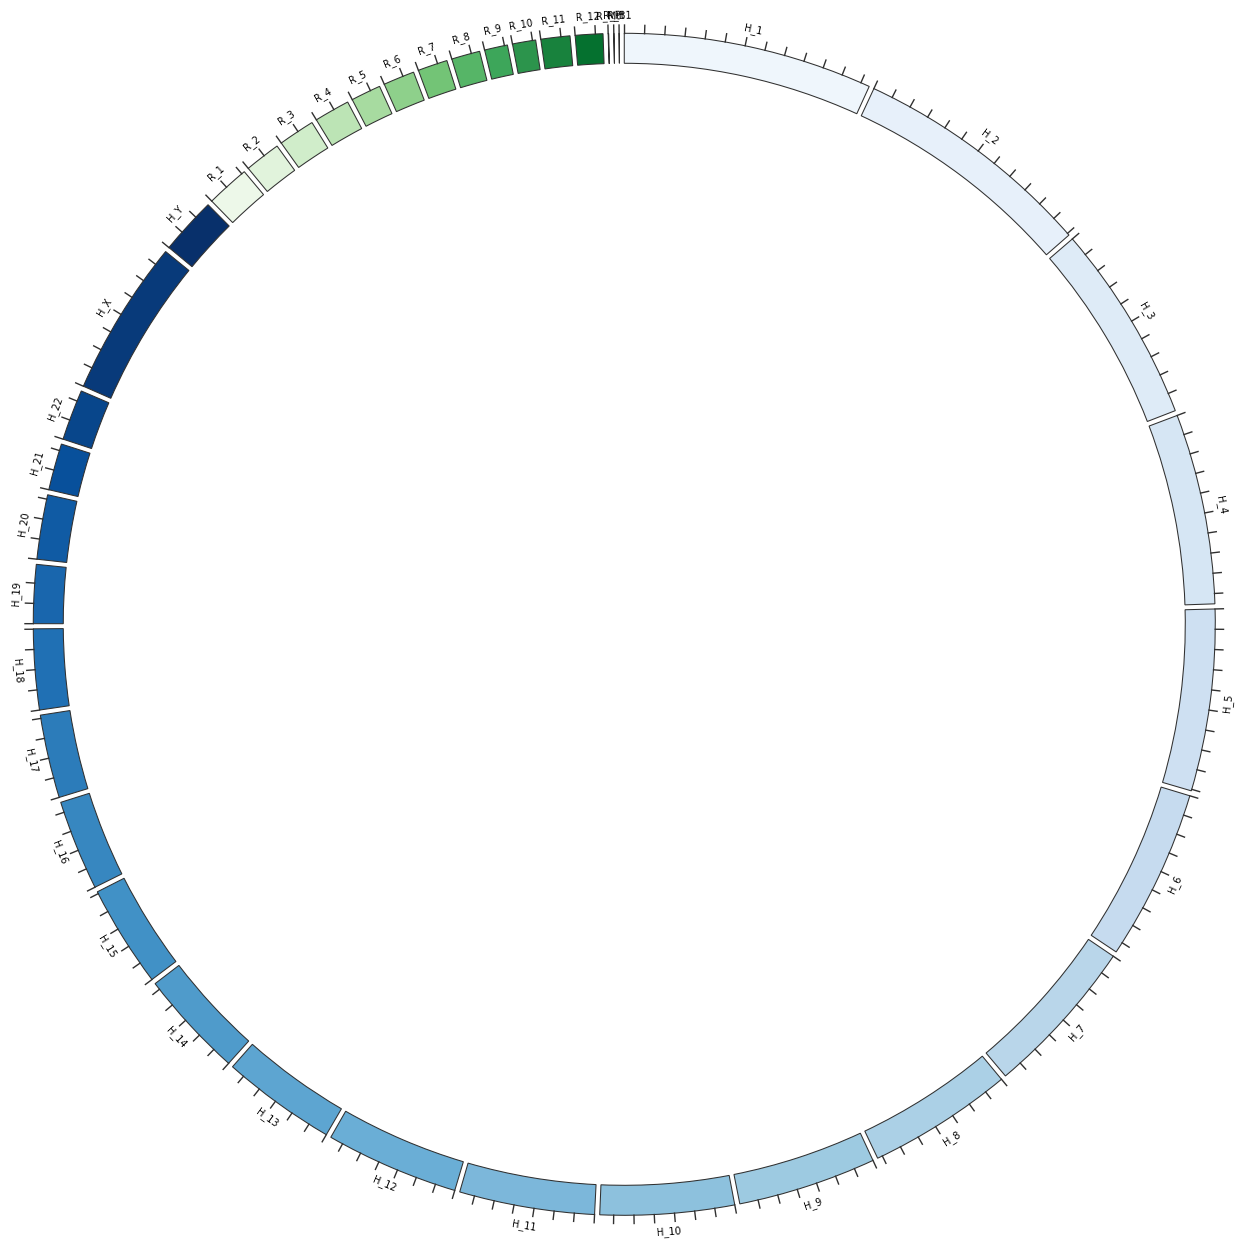

In [8]:
circle.figure

#### Scatter plot of human vs rice upregulated genes

In [9]:
#organism = "human"
df_h_score = pd.read_csv(HUMAN_SCORE, sep='\t')
df_h_score_subset = df_h_score[['Gene stable ID',
                        'Chromosome/scaffold name', 
                        'Gene start (bp)',
                        'Gene end (bp)',
                        'HN-score(HN5)']].copy()
df_h_score_subset['Chromosome/scaffold name'] = 'H_' + df_h_score_subset['Chromosome/scaffold name'].astype(str)
df_h_score_subset['organism'] = 'human'# タグをつける


# organism = "rice"
df_r_score = pd.read_csv(RICE_SCORE, sep='\t')
df_r_score_subset = df_r_score[['Gene stable ID',
                        'Chromosome/scaffold name', 
                        'Gene start (bp)',
                        'Gene end (bp)',
                        'HN-score(HN5)']].copy()
df_r_score_subset['Chromosome/scaffold name'] = 'R_' + df_r_score_subset['Chromosome/scaffold name'].astype(str)
df_r_score_subset['organism'] = 'rice'# タグをつける


# combined human and rice DataFrame
combined_df_score = pd.concat([df_h_score_subset, df_r_score_subset])
combined_df_score.reset_index(drop=True, inplace=True)
combined_df_score.to_csv(COMBINED_SCORE, sep='\t', index=False)
combined_df_score

Gene stable ID Chromosome/scaffold name  Gene start (bp)  Gene end (bp)  \
0    ENSG00000132952                     H_13         30617693       30660770   
1    ENSG00000198743                     H_21         34073578       34106260   
2    ENSG00000215547                     H_20         31257664       31259632   
3    ENSG00000139597                     H_13         32400723       32428311   
4    ENSG00000122035                     H_13         27270830       27275192   
..               ...                      ...              ...            ...   
570     Os08g0444440                      R_8         21644628       21646515   
571     Os07g0549800                      R_7         21823012       21825223   
572     Os01g0901600                      R_1         39257838       39261362   
573     Os08g0546800                      R_8         27382872       27384470   
574     Os04g0352400                      R_4         16813905       16817974   

     HN-score(HN5) organism  
0             89.0    human  
1             58.0    human  
2             83.0    human  
3             58.0    human  
4             58.0    human  
..             ...      ...  
570           71.0     rice  
571           57.0     rice  
572           52.0     rice  
573           73.0     rice  
574          227.0     rice  

[575 rows x 6 columns]

In [10]:
# Initialize
arcdata_dict = collections.defaultdict(dict)

for index, row in combined_df_score.iterrows():
    name = row['Chromosome/scaffold name']
    start = row['Gene start (bp)']
    end = row['Gene end (bp)']
    mid = (start + end) // 2
    value = row['HN-score(HN5)']

    if name not in arcdata_dict: # arcdata_dictにnameがない場合, arcdata_dictに追加
        arcdata_dict[name]["positions"] = []
        arcdata_dict[name]["values"] = []

    arcdata_dict[name]["positions"].append(mid)
    arcdata_dict[name]["values"].append(value)


# plot
vmin, vmax = combined_df_score['HN-score(HN5)'].min(), combined_df_score['HN-score(HN5)'].max()
for key in arcdata_dict:
    circle.scatterplot(
        key,
        data=arcdata_dict[key]["values"],
        positions=arcdata_dict[key]["positions"], 
        rlim=[vmin-0.05*abs(vmin), vmax+0.05*abs(vmax)],
        raxis_range=(840, 940),
        facecolor="orangered",
        edgecolor="black",
        spine=True
    )

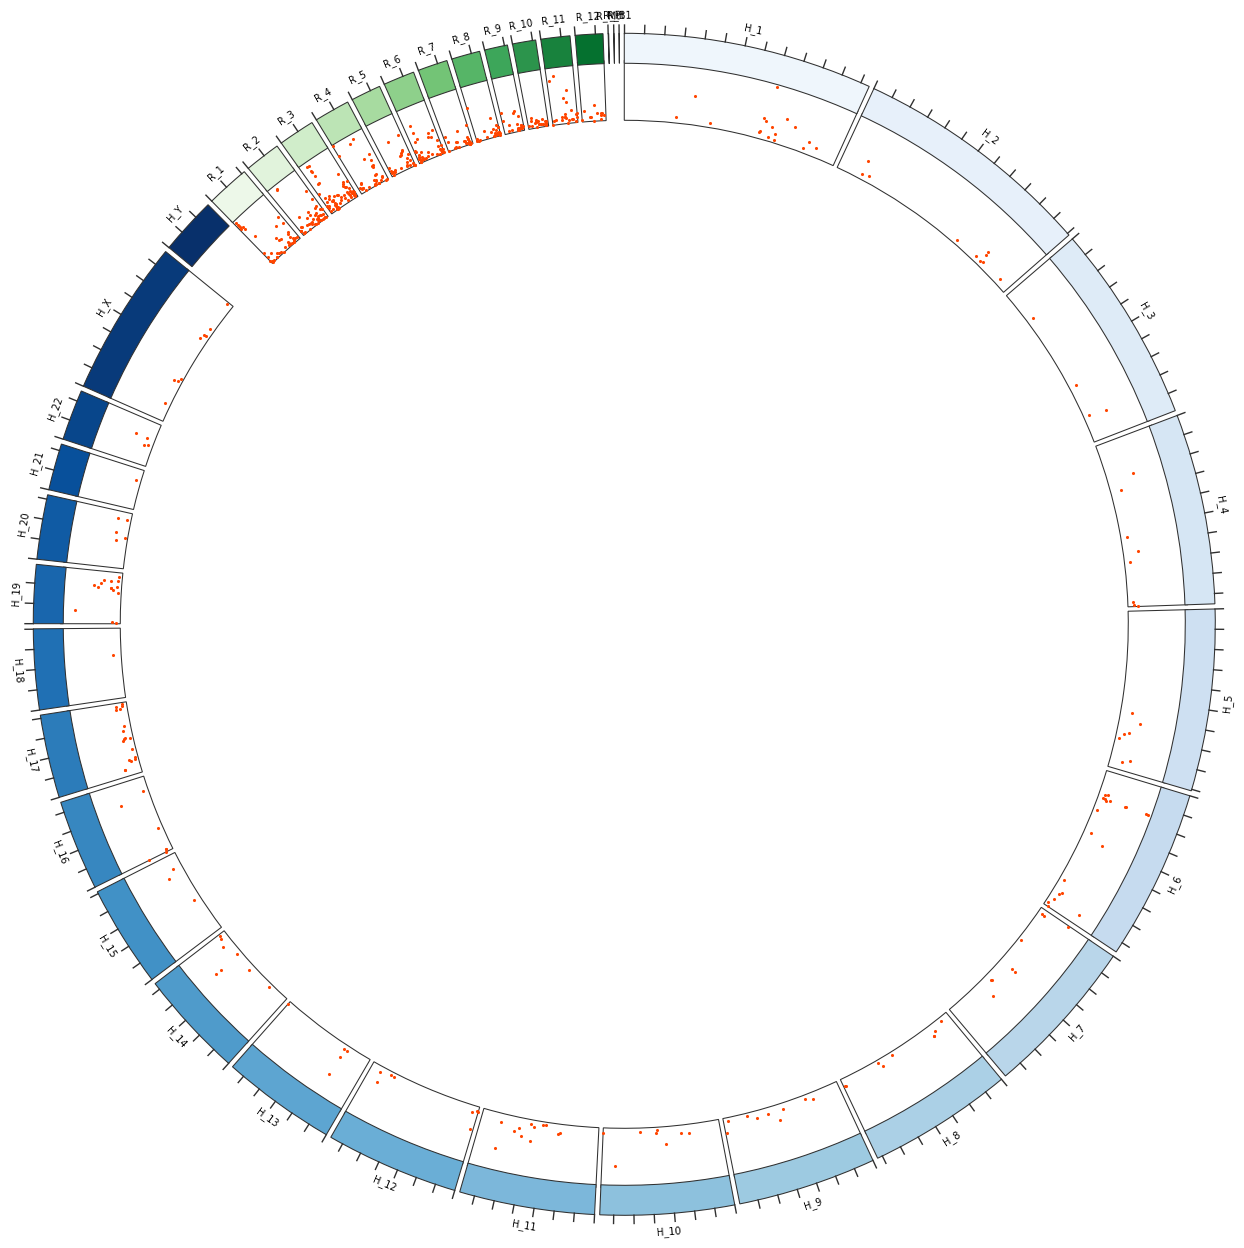

In [11]:
circle.figure

#### linkplot of GOslim terms for human vs rice upregulated genes

##### human

In [12]:
# Prepare the extract up genes data from GOslim file

# organism = "human"
# Using df_h_score_subset for extract up genes data from GOslim file
df_h_goslim = pd.read_csv(HUMAN_GOSLIM, sep='\t')
df_h_goslim['Chromosome/scaffold name'] = 'H_' + df_h_goslim['Chromosome/scaffold name'].astype(str)


extract_df_h_goslim = pd.merge(
    df_h_score_subset, df_h_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='inner'
)

# Extract genes with no annotations
extract_df_h_goslim_with_indicator = pd.merge(
    df_h_score_subset, df_h_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='left',
    indicator=True # add indicator column to show the difference
)

# extract_df_h_goslim_with_indicator
left_only_rows = extract_df_h_goslim_with_indicator[extract_df_h_goslim_with_indicator['_merge'] == 'left_only']

# left_only_rows
left_only_rows.to_csv(HUMAN_NO_ANNOTATION, sep='\t', index=False)
extract_df_h_goslim.to_csv(HUMAN_EXTRACT_GOSLIM_GENE, sep='\t', index=False)
extract_df_h_goslim


/tmp/ipykernel_75026/3480807121.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_h_goslim = pd.read_csv(HUMAN_GOSLIM, sep='\t')


Gene stable ID Chromosome/scaffold name  Gene start (bp)  \
0     ENSG00000132952                     H_13         30617693   
1     ENSG00000132952                     H_13         30617693   
2     ENSG00000132952                     H_13         30617693   
3     ENSG00000132952                     H_13         30617693   
4     ENSG00000132952                     H_13         30617693   
...               ...                      ...              ...   
4819  ENSG00000162772                      H_1        212565334   
4820  ENSG00000162772                      H_1        212565334   
4821  ENSG00000162772                      H_1        212565334   
4822  ENSG00000162772                      H_1        212565334   
4823  ENSG00000162772                      H_1        212565334   

      Gene end (bp)  HN-score(HN5) organism  start2 (bp)  end2 (bp)  \
0          30660770             89    human     30617693   30660770   
1          30660770             89    human     30617693   30660770   
2          30660770             89    human     30617693   30660770   
3          30660770             89    human     30617693   30660770   
4          30660770             89    human     30617693   30660770   
...             ...            ...      ...          ...        ...   
4819      212620777             88    human    212565334  212620777   
4820      212620777             88    human    212565334  212620777   
4821      212620777             88    human    212565334  212620777   
4822      212620777             88    human    212565334  212620777   
4823      212620777             88    human    212565334  212620777   

     GOSlim GOA Accession(s)                   GOSlim GOA Description  
0                 GO:0043226                                organelle  
1                 GO:0005634                                  nucleus  
2                 GO:0003824                       catalytic activity  
3                 GO:0016787                       hydrolase activity  
4                 GO:0140096  catalytic activity, acting on a protein  
...                      ...                                      ...  
4819              GO:0005654                              nucleoplasm  
4820              GO:0005730                                nucleolus  
4821              GO:0005694                               chromosome  
4822              GO:0023052                                signaling  
4823              GO:0012501                    programmed cell death  

[4824 rows x 10 columns]

##### rice

In [13]:
# organism = "rice"
# Using df_r_score_subset for extract up genes data from GOslim file

df_r_goslim = pd.read_csv(RICE_GOSLIM, sep='\t')
df_r_goslim['Chromosome/scaffold name'] = 'R_' + df_r_goslim['Chromosome/scaffold name'].astype(str)

extract_df_r_goslim = pd.merge(
    df_r_score_subset, df_r_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='inner'
)

# Extract genes with no annotations
extract_df_r_goslim_with_indicator = pd.merge(
    df_r_score_subset, df_r_goslim,
    left_on=['Gene stable ID', 'Chromosome/scaffold name'],
    right_on=['Gene stable ID', 'Chromosome/scaffold name'],
    how='left',
    indicator=True # add indicator column to show the difference
)

# extract_df_r_goslim_with_indicator
left_only_rows = extract_df_r_goslim_with_indicator[extract_df_r_goslim_with_indicator['_merge'] == 'left_only']

# left_only_rows
left_only_rows.to_csv(RICE_NO_ANNOTATION, sep='\t', index=False)
extract_df_r_goslim.to_csv(RICE_EXTRACT_GOSLIM_GENE, sep='\t', index=False)
extract_df_r_goslim

/tmp/ipykernel_75026/1793619523.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_r_goslim = pd.read_csv(RICE_GOSLIM, sep='\t')


Gene stable ID Chromosome/scaffold name  Gene start (bp)  Gene end (bp)  \
0      Os10g0419300                     R_10         14746572       14750175   
1      Os10g0419300                     R_10         14746572       14750175   
2      Os10g0419300                     R_10         14746572       14750175   
3      Os10g0419300                     R_10         14746572       14750175   
4      Os10g0419300                     R_10         14746572       14750175   
...             ...                      ...              ...            ...   
2814   Os04g0352400                      R_4         16813905       16817974   
2815   Os04g0352400                      R_4         16813905       16817974   
2816   Os04g0352400                      R_4         16813905       16817974   
2817   Os04g0352400                      R_4         16813905       16817974   
2818   Os04g0352400                      R_4         16813905       16817974   

      HN-score(HN5) organism  start1 (bp)  end1 (bp) GOSlim GOA Accession(s)  \
0              53.0     rice     14746572   14750175              GO:0003674   
1              53.0     rice     14746572   14750175              GO:0005488   
2              53.0     rice     14746572   14750175              GO:0003676   
3              53.0     rice     14746572   14750175              GO:0003677   
4              53.0     rice     14746572   14750175              GO:0005575   
...             ...      ...          ...        ...                     ...   
2814          227.0     rice     16813905   16817974              GO:0008152   
2815          227.0     rice     16813905   16817974              GO:0036211   
2816          227.0     rice     16813905   16817974              GO:0019538   
2817          227.0     rice     16813905   16817974              GO:0005515   
2818          227.0     rice     16813905   16817974              GO:0005488   

            GOSlim GOA Description  
0               molecular_function  
1                          binding  
2             nucleic acid binding  
3                      DNA binding  
4               cellular_component  
...                            ...  
2814             metabolic process  
2815  protein modification process  
2816     protein metabolic process  
2817               protein binding  
2818                       binding  

[2819 rows x 10 columns]

##### __Merge human and rice GOslim terms__

In [14]:
# merge dataframe based on common column 'GOSlim GOA Accession(s)'
merged_df_goslim = pd.merge(
    extract_df_r_goslim, 
    extract_df_h_goslim,
    left_on=['GOSlim GOA Accession(s)'],
    right_on=['GOSlim GOA Accession(s)'],
    how='inner',
    suffixes=('_rice', '_human')
)

# extract necessary columns

merged_df_goslim = merged_df_goslim[['GOSlim GOA Accession(s)',
                                     'GOSlim GOA Description_rice',
                                     'GOSlim GOA Description_human',
                                     'Gene stable ID_rice',
                                     'Gene stable ID_human',
                                     'Chromosome/scaffold name_rice',
                                     'start1 (bp)',
                                     'end1 (bp)',
                                     'Chromosome/scaffold name_human',
                                     'start2 (bp)',
                                     'end2 (bp)',
                                     'HN-score(HN5)_rice',
                                     'HN-score(HN5)_human']]

# Remove duplicate rows based on specific columns
merged_df_goslim.drop_duplicates(inplace=True)

# for debugging purpose
unique_accessions_r = set(extract_df_r_goslim['GOSlim GOA Accession(s)'].unique())
unique_accessions_h = set(extract_df_h_goslim['GOSlim GOA Accession(s)'].unique())
common_accessions = unique_accessions_r.intersection(unique_accessions_h)
unique_accessions_merged = set(merged_df_goslim['GOSlim GOA Accession(s)'].unique())
missing_accessions = common_accessions.difference(unique_accessions_merged)
print(f"Number of common accessions: {len(common_accessions)}")
print(f"Number of missing accessions: {len(missing_accessions)}")
print(f"Missing accessions: {missing_accessions}")

merged_df_goslim.to_csv(COMBINED_GOSLIM, sep='\t', index=False)
merged_df_goslim

Number of common accessions: 28
Number of missing accessions: 0
Missing accessions: set()


GOSlim GOA Accession(s) GOSlim GOA Description_rice  \
0                  GO:0003677                 DNA binding   
2                  GO:0003677                 DNA binding   
9                  GO:0003677                 DNA binding   
10                 GO:0003677                 DNA binding   
11                 GO:0003677                 DNA binding   
...                       ...                         ...   
51206              GO:0005856                cytoskeleton   
51207              GO:0005856                cytoskeleton   
51208              GO:0005856                cytoskeleton   
51216              GO:0005856                cytoskeleton   
51219              GO:0005856                cytoskeleton   

      GOSlim GOA Description_human Gene stable ID_rice Gene stable ID_human  \
0                      DNA binding        Os10g0419300      ENSG00000179388   
2                      DNA binding        Os10g0419300      ENSG00000170345   
9                      DNA binding        Os10g0419300      ENSG00000187559   
10                     DNA binding        Os10g0419300      ENSG00000204103   
11                     DNA binding        Os10g0419300      ENSG00000187475   
...                            ...                 ...                  ...   
51206                 cytoskeleton        Os01g0257300      ENSG00000184378   
51207                 cytoskeleton        Os01g0257300      ENSG00000004478   
51208                 cytoskeleton        Os01g0257300      ENSG00000149781   
51216                 cytoskeleton        Os01g0257300      ENSG00000168334   
51219                 cytoskeleton        Os01g0257300      ENSG00000178404   

      Chromosome/scaffold name_rice  start1 (bp)  end1 (bp)  \
0                              R_10     14746572   14750175   
2                              R_10     14746572   14750175   
9                              R_10     14746572   14750175   
10                             R_10     14746572   14750175   
11                             R_10     14746572   14750175   
...                             ...          ...        ...   
51206                           R_1      8586157    8586941   
51207                           R_1      8586157    8586941   
51208                           R_1      8586157    8586941   
51216                           R_1      8586157    8586941   
51219                           R_1      8586157    8586941   

      Chromosome/scaffold name_human  start2 (bp)  end2 (bp)  \
0                                H_8     22687659   22693480   
2                               H_14     75278826   75282230   
9                                H_9     68302867   68305084   
10                              H_20     40685848   40689236   
11                               H_6     26107412   26108135   
...                              ...          ...        ...   
51206                            H_3    169766921  169769561   
51207                           H_12      2794970    2805423   
51208                           H_11     64205926   64223896   
51216                            H_3     39183210   39192596   
51219                           H_17     78890579   78903217   

       HN-score(HN5)_rice  HN-score(HN5)_human  
0                    53.0                   69  
2                    53.0                  165  
9                    53.0                   64  
10                   53.0                   86  
11                   53.0                   72  
...                   ...                  ...  
51206                45.0                  126  
51207                45.0                  129  
51208                45.0                   53  
51216                45.0                   67  
51219                45.0                   57  

[14316 rows x 13 columns]

In [15]:
#Count the occurrences of each 'GOSlim GOA Accession(s)'
accession_counter = Counter(merged_df_goslim['GOSlim GOA Accession(s)'])

#Sort the DataFrame based on the counts
merged_df_goslim['count'] = merged_df_goslim['GOSlim GOA Accession(s)'].map(accession_counter)
merged_df_goslim_sorted = merged_df_goslim.sort_values('count', ascending=False).drop('count', axis=1)

merged_df_goslim_sorted.to_csv(COMBINED_GOSLIM_SORTED, sep='\t', index=False)
merged_df_goslim_sorted


GOSlim GOA Accession(s)   GOSlim GOA Description_rice  \
28315              GO:0003824            catalytic activity   
21501              GO:0003824            catalytic activity   
21491              GO:0003824            catalytic activity   
21486              GO:0003824            catalytic activity   
21477              GO:0003824            catalytic activity   
...                       ...                           ...   
46613              GO:0005198  structural molecule activity   
46617              GO:0005198  structural molecule activity   
50470              GO:0005777                    peroxisome   
50469              GO:0005777                    peroxisome   
50751              GO:0005840                      ribosome   

       GOSlim GOA Description_human Gene stable ID_rice Gene stable ID_human  \
28315            catalytic activity        Os05g0519700      ENSG00000104808   
21501            catalytic activity        Os02g0630300      ENSG00000146453   
21491            catalytic activity        Os02g0630300      ENSG00000139908   
21486            catalytic activity        Os02g0630300      ENSG00000118514   
21477            catalytic activity        Os02g0630300      ENSG00000130822   
...                             ...                 ...                  ...   
46613  structural molecule activity        Os01g0105800      ENSG00000184697   
46617  structural molecule activity        Os01g0105800      ENSG00000109846   
50470                    peroxisome        Os07g0529000      ENSG00000165507   
50469                    peroxisome        Os06g0253100      ENSG00000165507   
50751                      ribosome        Os11g0303800      ENSG00000112110   

      Chromosome/scaffold name_rice  start1 (bp)  end1 (bp)  \
28315                           R_5     25803609   25807160   
21501                           R_2     25199505   25203742   
21491                           R_2     25199505   25203742   
21486                           R_2     25199505   25203742   
21477                           R_2     25199505   25203742   
...                             ...          ...        ...   
46613                           R_1       306871     308842   
46617                           R_1       306871     308842   
50470                           R_7     20691213   20693521   
50469                           R_6      7940956    7941680   
50751                          R_11     11436951   11446262   

      Chromosome/scaffold name_human  start2 (bp)  end2 (bp)  \
28315                           H_19     48933699   48944969   
21501                            H_6    159800249  159820704   
21491                           H_14     24205696   24208362   
21486                            H_6    134917393  134950115   
21477                            H_X    153669733  153689010   
...                              ...          ...        ...   
46613                           H_16      3014712    3020071   
46617                           H_11    111908564  111923722   
50470                           H_10     44970981   44978809   
50469                           H_10     44970981   44978809   
50751                            H_6    159789812  159798436   

       HN-score(HN5)_rice  HN-score(HN5)_human  
28315               171.0                   82  
21501                58.0                  175  
21491                58.0                   55  
21486                58.0                   57  
21477                58.0                   64  
...                   ...                  ...  
46613                53.0                   65  
46617                53.0                  173  
50470                59.0                   70  
50469               129.0                   70  
50751                65.0                   63  

[14316 rows x 13 columns]

In [16]:
# Add color data to 'GOSlim GOA Description' column
unique_ontologies = merged_df_goslim_sorted['GOSlim GOA Description_rice'].unique()

n = len(unique_ontologies)
colors = cm.rainbow(np.linspace(0, 1, n)) # create n colors by cm.rainbow

# create ontology_color_dict
ontology_color_dict = {term: color for term, color in zip(unique_ontologies, colors)}

# add to garc_dict
for term, color in ontology_color_dict.items():
    circle._garc_dict[term] = {'facecolor': color, 'edgecolor': color}

In [17]:
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)

# Count the number of ontology terms
ontology_count = Counter()
with open(COMBINED_GOSLIM_SORTED, mode='r', newline='') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        ontology = row['GOSlim GOA Description_rice']
        ontology_count[ontology] += 1

min_linewidth = 1 * 10**-40
max_linewidth = 0.002

min_count = min(ontology_count.values())
max_count = max(ontology_count.values())


with open(COMBINED_GOSLIM_SORTED, mode='r', newline='') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        name1 = row['Chromosome/scaffold name_rice'] # rice
        start1 = int(row['start1 (bp)'])
        end1 = int(row['end1 (bp)'])
        name2 = row['Chromosome/scaffold name_human'] # human
        start2 = int(row['start2 (bp)'])
        end2 = int(row['end2 (bp)'])
        ontology = row['GOSlim GOA Description_rice']

        # For debugging
        print("Debugging Info:")
        print(f"ontology: {ontology}")
        print(f"circle._garc_dict[ontology]: {circle._garc_dict.get(ontology, 'Not found')}")

        count = ontology_count[ontology]
        linewidth = min_linewidth + (max_linewidth - min_linewidth) * ((count - min_count) / (max_count - min_count))
        
        source = (name1, start1, end1, 840)
        destination = (name2, start2, end2, 840)
        circle.chord_plot(source, 
                          destination, 
                          facecolor=circle._garc_dict[ontology]['facecolor'],
                          linewidth=linewidth,
                          edgecolor=circle._garc_dict[ontology]['edgecolor']
                          )

Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
circle._garc_dict[ontology]: {'facecolor': array([0.5, 0. , 1. , 1. ]), 'edgecolor': array([0.5, 0. , 1. , 1. ])}
Debugging Info:
ontology: catalytic activity
c

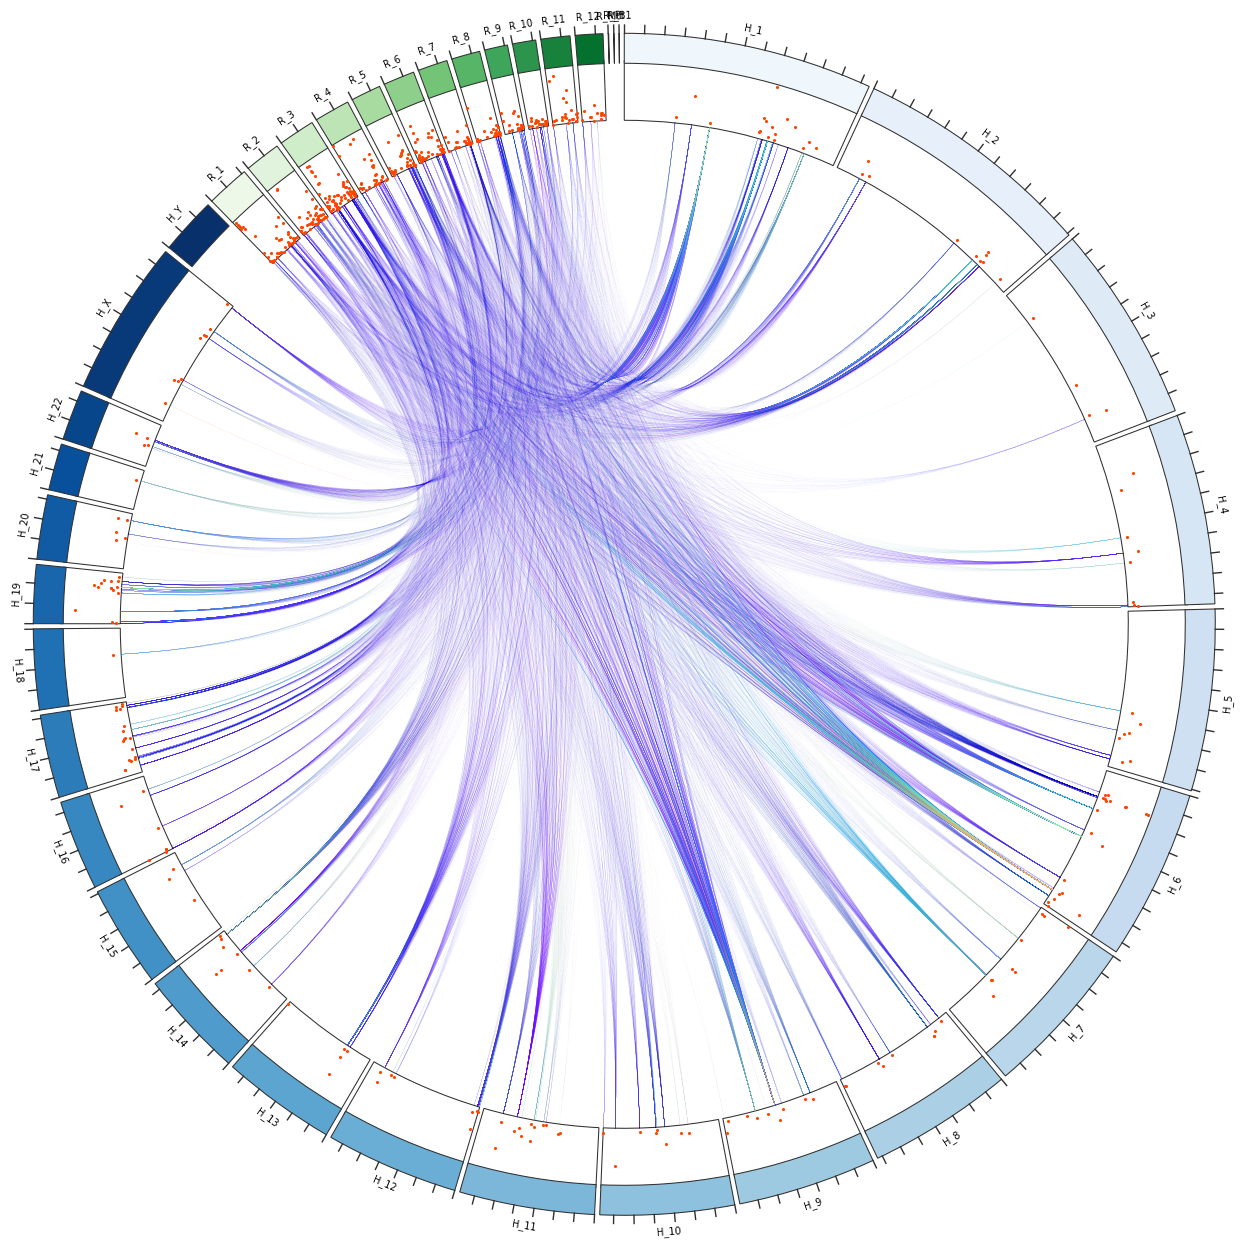

In [18]:
circle.figure

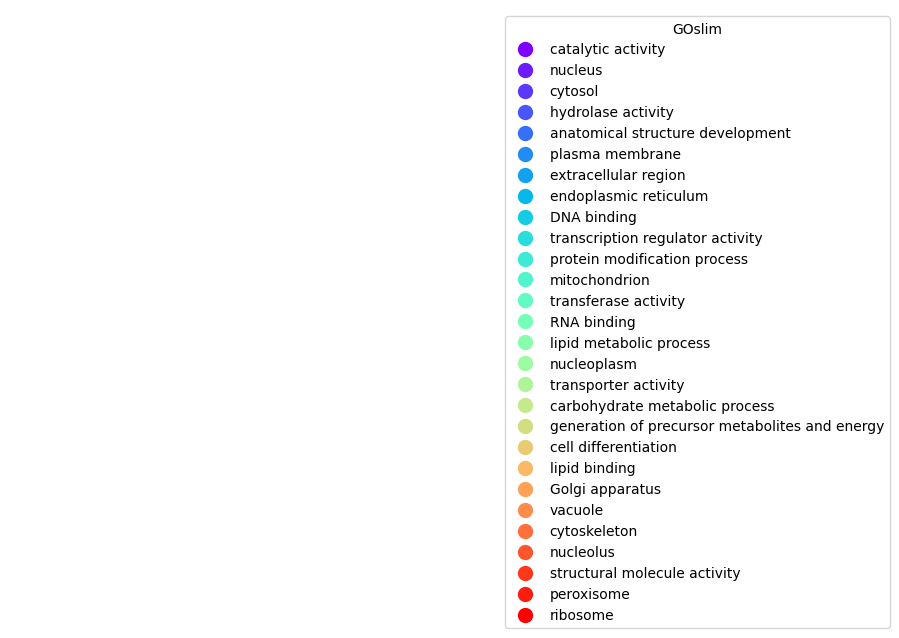

In [19]:
# add legend as a independent figure
fig, ax = plt.subplots(figsize=(6, 6))
for ontology, color in ontology_color_dict.items():
    ax.plot([], [], label=ontology, color=color, marker='o', markersize=10, linestyle='None')

ax.legend(title="GOslim", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axis('off')
plt.show()
